# Import Moduel

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import sqlite3
import pymongo
from wordcloud import WordCloud
# 設定中文字型為微軟正黑體
mpl.rcParams['font.family'] = 'Microsoft JhengHei' 

# Load Data

In [2]:
def get_sqlData(table_name, dbname = "Jobsearch_database.db"):
    conn = sqlite3.connect(dbname)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df

In [3]:
# SQL
df = get_sqlData('JobsInfo')
print(df.shape)

(2244, 23)


# Data merge from different tables

In [4]:
def pandas_method(table_name : str, join_column : str, Dimension_column : str) -> pd.DataFrame:
    df1 = get_sqlData("JobsInfo")
    df2 = get_sqlData(table_name)
    df = pd.merge(df1, df2, left_on = join_column, right_on = "id", how = "inner")
    df = df[[Dimension_column]]
    return df.rename(columns={Dimension_column: join_column})


def sql_method(join_table_name : str, join_column : str, Dimension_column : str) -> pd.DataFrame:
    conn = sqlite3.connect("Jobsearch_database.db")
    query = f'''
        SELECT
            t2.{Dimension_column} AS {join_column}
        FROM
            JobsInfo AS t1
        JOIN
            {join_table_name} AS t2
        ON
            t1.{join_column} = t2.id
        
    '''
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# EDA

In [5]:
def horizontal_countplot(df : pd.DataFrame, column_name : str, ax = None):
    if ax is None:
        ax = plt.gca()
    
    order = df[column_name].value_counts().index
    ax = sns.countplot(data=df, y=column_name, order=order, ax=ax)
    for p in ax.patches:
        w = int(p.get_width())
        ax.annotate(f'{w}', (w, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=10, color='black', xytext=(2, 0),
                    textcoords='offset points')

    max_count = df[column_name].value_counts().max()
    max_x = ((max_count + 100) // 100 + 1) * 100
    ax.set_xlim(0, max_x) 
    plt.xlabel('Counts')
    plt.ylabel('')

def Vertical_countplot(df, column_name, ax=None):
    if ax is None:
        ax = plt.gca()  # 如果未提供 ax，則使用當前的 Axes
    sns.countplot(data=df, x=column_name, ax=ax)
    for p in ax.patches:
        h = int(p.get_height())
        ax.annotate(f'{h}', (p.get_x() + p.get_width() / 2., h),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    ax.set_ylabel('Counts')

## 縣市、工作經驗

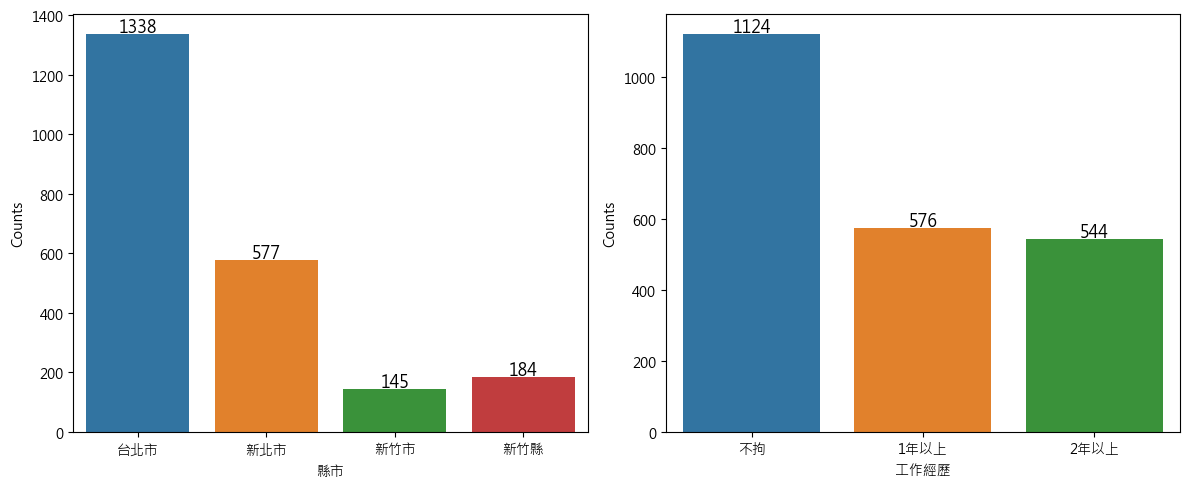

In [6]:
# OR
# city_df = pandas_method("City", "縣市", "city")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
Vertical_countplot(sql_method("City", "縣市", "city"), "縣市", axes[0])
Vertical_countplot(sql_method("WorkingEXP", "工作經歷", "yearexp"), "工作經歷", axes[1])
plt.tight_layout()
plt.show()

## 學歷要求、科系要求

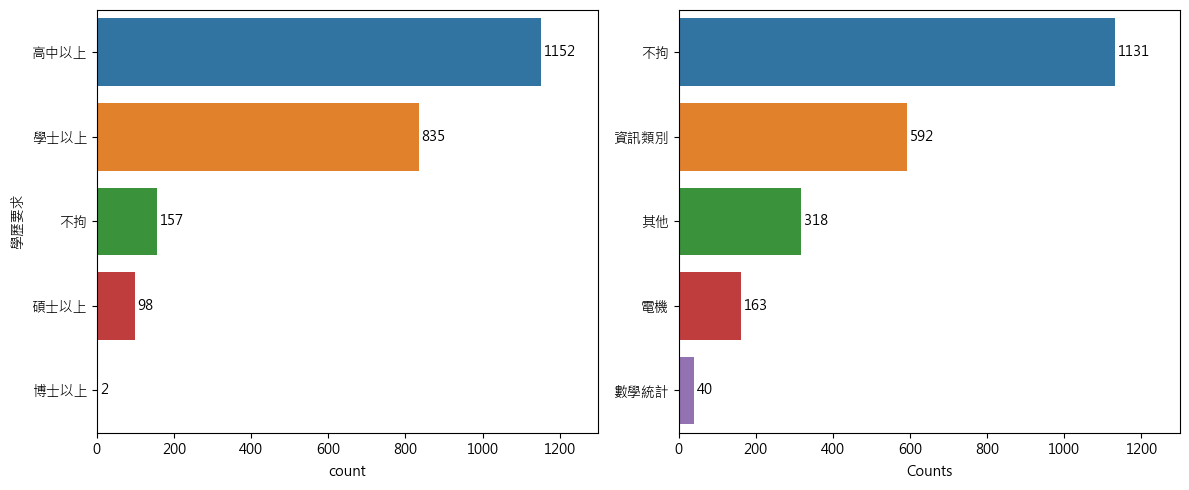

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
horizontal_countplot(sql_method("Degree", "學歷要求", "degree"), "學歷要求", axes[0])
horizontal_countplot(sql_method("Department", "科系要求", "department"), "科系要求", axes[1])
plt.tight_layout()
plt.show()

## 常用工具

In [8]:
def tool_count(df):
    # 定義常見軟體業tool
    tool = {
        'Python': 0, 'C++': 0, 'Java': 0, 'JavaScript': 0, 'R':0,
        'C#': 0, 'C': 0, 'PHP': 0, 'Go': 0, '.NET': 0, 'HTML': 0,
        'SQL': 0, 'Swift': 0, 'MATLAB': 0, 'Ruby': 0, 'CSS': 0, 'Node.js': 0,
        'Linux': 0, 'Git': 0, 'Github': 0, 'Jquery':0, 'Vue': 0,
    }
    
    for k in tool.keys():
        if k == 'C++':
            tool[k] = df['擅長工具'].str.contains('C\+\+', case=False).sum()
        elif k == 'R':
            tool[k] = df['擅長工具'].apply(lambda x:bool(re.findall(r'R(?![A-Za-z])', x))).sum()
        elif k == 'C':
            tool[k] = df['擅長工具'].apply(lambda x:bool(re.findall(r'C(?![A-Za-z+#])', x))).sum()
        else:
            tool[k] = df['擅長工具'].str.contains(k, case=False).sum()
    tool_df = pd.DataFrame.from_dict(tool, orient='index', columns=['Count']).sort_values('Count')

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    tool_df.plot(kind='barh', legend=None, ax=ax1)
    for i, v in enumerate(tool_df['Count']):
        ax1.text(v, i-0.2, str(v), fontsize=9)
    ax1.set_xlabel('Counts')
    
    spine_alpha = 0.1
    for spine in ax1.spines.values():
        spine.set_alpha(spine_alpha)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    # ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)

    # word cloud
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(tool)
    ax2.imshow(wordcloud, interpolation='bilinear')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return tool_df

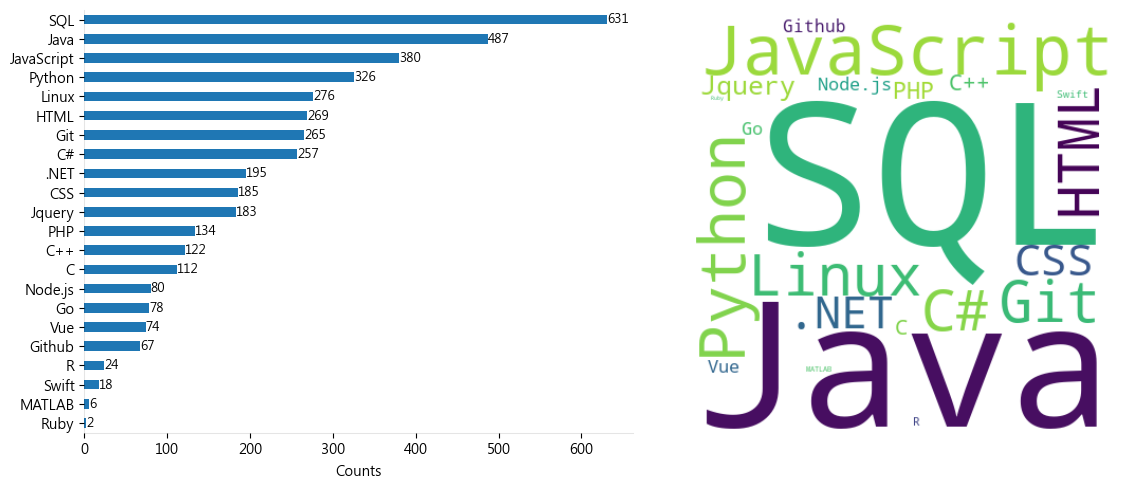

In [11]:
ndf = tool_count(df)